<a href="https://colab.research.google.com/github/jamsun9907/Sentiment_analysis_game_review/blob/main/Section_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 4 Project
## Sentiment analysis 

## Data processing

### Configuration

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Konlp 사이트 참고
https://konlpy.org/en/v0.6.0/api/konlpy.tag/

In [ ]:
# Colab에 Mecab 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 11.9 MB/s 
     |████████████████████████████████| 465 kB 16.9 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-12-04 01:08:15--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 18.205.93.2, 18.205.93.1, 18.205.93.0, ...
Connecting to bitbucket.org (bitbucket.org)|18.205.93.2|:44

### Data loading

In [ ]:
## config
from google.colab import files
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from konlpy.tag import Mecab, Kkma, Okt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
path = '/content/drive/MyDrive/0.Data for analysis/Project/steam.txt'

df = pd.read_csv(path, sep = '\t', header=None, names = ['label', 'reviews'])

df.head(5)

,label,reviews
0,0,노래가 너무 적음
1,0,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,1,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,1,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,1,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


In [ ]:
print('Total reviews : ', len(df))
print('중복 제거 샘플')
df['label'].nunique(), df['reviews'].nunique()

Total reviews :  100000
중복 제거 샘플


(2, 99892)

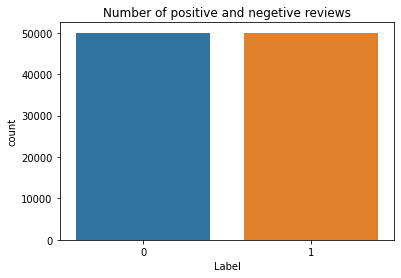

In [ ]:
# label 비율 확인
sns.countplot(x = 'label', data = df)
plt.xlabel('Label')
plt.title('Number of positive and negetive reviews');

### 전처리

In [ ]:
# 중복제거
df_clean = df.copy()
df.drop_duplicates(subset = 'reviews', inplace = True)

# Null 확인
df_clean.isna().sum() # 없음

label      0
reviews    0
dtype: int64

In [ ]:
# 리뷰 데이터 전처리
label = df_clean['label']
target = pd.DataFrame(df_clean['reviews'])

target.head(5)

,reviews
0,노래가 너무 적음
1,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요


**텍스트 데이터 전처리 해줄 함수를 정의**

In [ ]:
def processing(sentence):
    pat = re.compile('[^\w ]')
    sent = re.sub(pat,'', sentence)
    return sent

In [ ]:
# 이모티콘 태깅이 된다면 굳이 전처리할 필요가 없지...
# target = target.apply(lambda x:processing(x))

In [ ]:
# checking
target.head(10)

,reviews
0,노래가 너무 적음
1,"돌겠네 진짜. 황숙아, 어크 공장 그만 돌려라. 죽는다."
2,막노동 체험판 막노동 하는사람인데 장비를 내가 사야돼 뭐지
3,차악!차악!!차악!!! 정말 이래서 왕국을 되찾을 수 있는거야??
4,시간 때우기에 좋음.. 도전과제는 50시간이면 다 깰 수 있어요
5,역시 재미있네요 전작에서 할수 없었던 자유로운 덱 빌딩도 좋네요^^
6,재미있었습니다.
7,은근 쉽지만 은근 어려운 게임
8,베ㅈ스다 이 개^ㅐ끼들아. 시작할 때 체스판 돌아가는거 5분동안 3번 봤더나 ㅈㄴ ...
9,1시간 40분동안 스트레스 다 풀림 ㄹㅇ


### Tokenize / stopwords / normalize / POS tagging
- 토큰화는 Twitter를 사용한다. (인터넷 텍스트에 강하다는 특징), (Kkma가 시간은 17배 더 오래걸리는데 성능이 그렇게 좋아지는지는 모르겠음) 
- 추후 성능을 비교하는 걸로
- 극성을 가지는 단어는 명사, 동사, 형용사이므로 토큰화에도 이 셋만 포함(책 참고)

**참고** https://needjarvis.tistory.com/691   
https://velog.io/@metterian/%ED%95%9C%EA%B5%AD%EC%96%B4-%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D%EA%B8%B0POS-%EB%B6%84%EC%84%9D-3%ED%8E%B8.-%ED%98%95%ED%83%9C%EC%86%8C-%EB%B6%84%EC%84%9D%EA%B8%B0-%EB%B9%84%EA%B5%90

In [ ]:
# kkma = Kkma() # 확실히 오래걸림 17초
# kkma.morphs(X_train[5]) # 성능이 더 좋은지는 모르겠음. 추후 하이퍼 파라미터 튜닝이 가능하다면 성능비교해보자

POS list 참고   
https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0

In [ ]:
# tokenizing

okt = Okt()

def twit_tokenizer(text):
    # 불용어 대신 필요 없는 품사를 제거
    pos = ['Noun','Verb','Adjective','Exclamation', 'KoreanParticle'] # 관형사는 보통 한글자로 의미 알기 힘듦. 

    result = []
    for token, tag in okt.pos(text, norm=True, stem=True) :
        if tag in pos: 
            result.append(token) # steming / normalizing 도 된다....
    return result

토큰 목록은 후에 워드 클라우드 등에서 사용하기

In [ ]:
target['tokenized'] = target['reviews'].apply(lambda x: twit_tokenizer(x)) # 12분

tokens = np.hstack(target['tokenized'].values)

print('# of tokens : ',len(tokens))
tokens[:10]

# of tokens :  1216945


array(['노래', '적다', '돌다', '진짜', '황숙', '어크', '공장', '돌리다', '죽다', '막노동'],
      dtype='<U32')

In [ ]:
# 가장 흔한 단어
word_cnt = Counter(tokens)

word_cnt.most_common(20)

[('하다', 71474),
 ('게임', 45198),
 ('있다', 16394),
 ('없다', 14719),
 ('되다', 11321),
 ('좋다', 10539),
 ('같다', 10094),
 ('재밌다', 9539),
 ('겜', 8157),
 ('이다', 7672),
 ('것', 7394),
 ('보다', 7318),
 ('않다', 7232),
 ('이', 7045),
 ('아니다', 6872),
 ('플레이', 6203),
 ('좀', 5389),
 ('안되다', 5134),
 ('때', 5104),
 ('사다', 5071)]

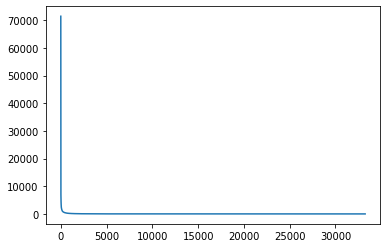

In [ ]:
# 전체 단어 빈도 수
sorted_cnt = sorted(word_cnt, key = word_cnt.get, reverse = True)

w = [word_cnt[key] for key in sorted_cnt]
plt.plot(w)
plt.show() # 대부분 단어가 매우 적게 사용된다.

In [ ]:
# 워드 클라우드 추가하기


### Word Embedding
- TF-IDF 벡터화

In [ ]:
# split
X_train, X_test, y_train, y_test = train_test_split(target['reviews'], label, test_size = 0.25, random_state = 42)

print('Train set count :', len(X_train))
print('Test set count :', len(X_test))

Train set count : 75000
Test set count : 25000


In [ ]:
# Tokenizing(13 min)
max_words = 10000
max_len = 1500 # 스크랩 데이터 보고 추후 조정

tok = Tokenizer(num_words=max_words, analyzer = twit_tokenizer) # 내가 만든 토크나이저 사용 
tok.fit_on_texts(X_train) 

sequences = tok.texts_to_sequences(X_train)

# Padding
sequences_matrix = pad_sequences(sequences, maxlen = max_len)

print('Total data : ', len(sequences_matrix), '\nPadding : ', len(sequences_matrix[0]))

Total data :  75000 
Padding :  1500


In [ ]:
# Save tokenized data(sequence)
df_seq = pd.DataFrame(sequences_matrix)
df_seq['label'] = y_train
df_seq


# df_seq.to_csv('sequence.csv')
# files.download('sequence.csv')

,0,1,2,3,4,5,6,7,8,9,...,1491,1492,1493,1494,1495,1496,1497,1498,1499,label
0,0,0,0,0,0,0,0,0,0,0,...,8086,2838,854,1140,749,2838,1,43,3,0.0
1,0,0,0,0,0,0,0,0,0,0,...,4318,341,32,3,6804,1,3,1197,2228,0.0
2,0,0,0,0,0,0,0,0,0,0,...,9,724,889,475,830,803,19,2899,2,1.0
3,0,0,0,0,0,0,0,0,0,0,...,2,27,73,106,2,22,40,1198,106,1.0
4,0,0,0,0,0,0,0,0,0,0,...,388,111,2,145,355,137,11,1132,66,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5934,5,2852,2747,1.0
74996,0,0,0,0,0,0,0,0,0,0,...,1,8212,110,2083,64,76,2238,518,4,0.0
74997,0,0,0,0,0,0,0,0,0,0,...,75,150,911,626,172,214,1,3,569,0.0
74998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,567,46,530,277,1.0


# 내가 만든 모델들

### 평가 함수

In [ ]:
# 성능확인 함수
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b',label = 'Training ' + metric)
    plt.plot(history.history['val_'+metric], 'r--', label = 'Validation '+ metric)
    plt.title('Training and validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

## RNN(LSTM)
- 테스트셋 성능 0.77

### 과제 내용을 복붙하면 어느정도 성능이 나올까
과제 모델 : Baseline
- RNN(LSTM) 모델

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.callbacks import EarlyStopping
from google.colab import files

In [ ]:
def RNN_Baseline():
    max_words = 10000
    max_len = 500

    # Input
    inputs = Input(name = 'inputs', shape = [max_len])
    layer = Embedding(input_dim = max_words, output_dim = 50, input_length = max_len)(inputs) # 50차원으로 Embed

    # LSTM
    layer = LSTM(64)(layer) 

    # FC
    layer = Dense(256, activation = 'relu', name = 'FC1')(layer) 
    layer = Dropout(0.5)(layer)

    # Output
    layer = Dense(1, activation = 'sigmoid', name = 'out_layer')(layer)
    
    model = Model(inputs = inputs, outputs = layer) 
    return model

In [ ]:
model = RNN_Baseline()
model.summary()
model.compile(optimizer = RMSprop(), loss = 'binary_crossentropy', metrics = ['acc']) # RMSprop() optimizer 알아보기

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1500)]            0         
                                                                 
 embedding (Embedding)       (None, 1500, 50)          500000    
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

In [ ]:
history = model.fit(sequences_matrix, y_train,batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)]) 

# Baseline 모델 저장
model.save('Sentiment_baseline.h5')
files.download('Sentiment_baseline.h5')  # from colab to browser download

Epoch 1/10
469/469 [==============================] - 47s 81ms/step - loss: 0.5414 - acc: 0.7304 - val_loss: 0.4843 - val_acc: 0.7715
Epoch 2/10
469/469 [==============================] - 41s 88ms/step - loss: 0.4736 - acc: 0.7778 - val_loss: 0.4828 - val_acc: 0.7652
Epoch 3/10
469/469 [==============================] - 37s 79ms/step - loss: 0.4498 - acc: 0.7930 - val_loss: 0.4793 - val_acc: 0.7729
Epoch 4/10
469/469 [==============================] - 37s 80ms/step - loss: 0.4325 - acc: 0.8005 - val_loss: 0.4760 - val_acc: 0.7751
Epoch 5/10
469/469 [==============================] - 37s 80ms/step - loss: 0.4226 - acc: 0.8070 - val_loss: 0.4775 - val_acc: 0.7745
Epoch 6/10
469/469 [==============================] - 37s 80ms/step - loss: 0.4042 - acc: 0.8169 - val_loss: 0.4821 - val_acc: 0.7715
Epoch 7/10
469/469 [==============================] - 37s 80ms/step - loss: 0.3864 - acc: 0.8284 - val_loss: 0.4960 - val_acc: 0.7701


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Prediction
test_sequences = tok.texts_to_sequences(X_test) # X_test도 동일하게 전처리
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len)

print('Total data : ', len(test_sequences_matrix), '\nPadding : ', len(test_sequences_matrix[0]))

# Evaludation
accr = model.evaluate(test_sequences_matrix, y_test)

Total data :  25000 
Padding :  1500
782/782 [==============================] - 15s 19ms/step - loss: 0.4906 - acc: 0.7756


In [ ]:
print('Test set\n Loss : {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

Test set
 Loss : 0.491
 Accuracy: 0.776


정확도 약 0.77의 약간 아쉬운 성능을 보임

## Bidirectional LSTM
- 양방향으로 본다
- 테스트셋 성능 : 

In [ ]:
# X_test도 동일하게 전처리
test_sequences = tok.texts_to_sequences(X_test) 
test_sequences_matrix = pad_sequences(test_sequences, maxlen = max_len)

print('Total data : ', len(test_sequences_matrix), '\nPadding : ', len(test_sequences_matrix[0]))


Total data :  25000 
Padding :  1500


In [ ]:
from tensorflow.keras.layers import Bidirectional

max_words = 10000
max_len = 1500

# Input
inputs = Input(name = 'inputs', shape = [max_len])
layer = Embedding(input_dim = max_words, output_dim = 50, input_length = max_len)(inputs) 
layer = Bidirectional(LSTM(64))(layer) 
layer = Dense(256, activation = 'relu', name = 'FC1')(layer) 
layer = Dropout(0.5)(layer)
layer = Dense(1, activation = 'sigmoid', name = 'out_layer')(layer)

model = Model(inputs = inputs, outputs = layer)
model.summary()

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

histroy = model.fit(sequences_matrix, y_train, epochs=6,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)]) 

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1500)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1500, 50)          500000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                           

NameError: ignored

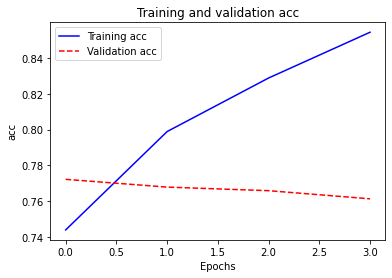

782/782 [==============================] - 175s 224ms/step - loss: 0.5715 - acc: 0.7652
#Test acc:0.765


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plot_results(histroy, 'acc')

# Evaluation
score = model.evaluate(test_sequences_matrix, y_test)
print(f'#Test acc:{score[1]:.3f}')

# Save
model.save('Sentiment_Bi_LSTM.h5')
files.download('Sentiment_Bi_LSTM.h5')  # from colab to browser download

# 남의것 쓴 모델들

### 평가 함수

In [ ]:
# 성능확인 함수
import matplotlib.pyplot as plt

def plot_results(history, metric):
    plt.plot(history.history[metric], 'b',label = 'Training ' + metric)
    plt.plot(history.history['val_'+metric], 'r--', label = 'Validation '+ metric)
    plt.title('Training and validation '+metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

## Small BERT
- 빠른 fine-tune을 위해 작은 모델부터 시작해본다.   

**아래는 Tensorflow의 모델 선택 조언**   
The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

**참고 사이트** 
https://towardsdatascience.com/multi-label-text-classification-using-bert-and-tensorflow-d2e88d8f488d

In [ ]:
# A dependency of the preprocessing for BERT inputs
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 35.2 MB/s 
     |████████████████████████████████| 588.3 MB 19 kB/s 
     |████████████████████████████████| 439 kB 68.3 MB/s 
     |████████████████████████████████| 6.0 MB 65.2 MB/s 
     |████████████████████████████████| 1.7 MB 65.0 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.

In [ ]:
# !pip install -q tf-models-official==2.7.0

In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [ ]:
# Data
path = '/content/drive/MyDrive/0.Data for analysis/Project/steam.txt'
df = pd.read_csv(path, sep = '\t', header=None, names = ['label', 'reviews'])

# 중복제거
df.drop_duplicates(subset = 'reviews', inplace = True)

# 리뷰 데이터 전처리
label = df['label']
feature = df.drop('label', axis = 1)

dataset = tf.data.Dataset.from_tensor_slices((feature.values, label.values))

# split
X_train, X_test, y_train, y_test = train_test_split(feature, label, test_size = 0.25, random_state = 42)

print('Train set count :', len(X_train))
print('Test set count :', len(X_test))

# # split
# BUFFER_SIZE = None
# BATCH_SIZE = None
# dataset = dataset.shuffle(BUFFER_SIZE)
# # print('Train set count :', len(X_train))
# # print('Test set count :', len(X_test))

Train set count : 74919
Test set count : 24973


### Preprocessing & Embedding

In [ ]:
preprocessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', name = 'preprocessing') # BERT Input 만드는 모델
encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1', name = 'embedding') # BERT Output 만드는 모델

# # multi-language
# preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
# encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

In [ ]:
# 양산형 모델 빌더 만들기...
def build_classifier_model(preprocessor = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1'):
    """
    Arg:
    preprocessor = 사용하려는 Model processor 주소 (Ex.'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
    encoder = 사용하려는 Model encoder 주소 (Ex. 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1')
    """
    # Input
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Embedding
    x = hub.KerasLayer(preprocessor, name = 'preprocessing')(input)
    x = hub.KerasLayer(encoder, name = 'embedding')(x)

    # Neural network
    x = tf.keras.layers.Dropout(0.1, name = 'dropout')(x['pooled_output']) # dropout은 왜? 없어도 되나? 성능 실험해보기
    x = tf.keras.layers.Dense(1, activation=None, name='classifier')(x)

    return tf.keras.Model(input, x)

In [ ]:
# BERT 전처리 모델 sample
text_test = ['this is such an amazing movie!']
text_preprocessed = preprocessor(text_test) # 토크나이징 등 전처리 수행 함수

# Preprocessing
print(f'\nPreprocessing\nKeys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

bert_results = encoder(preprocessor(text_test))

# Encoding
print(f'\nEncoding\nPooled Outputs Shape:{bert_results["pooled_output"].shape}') # Bert embedding
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}') # 얘는 뭔지 아직 잘 모르겠음


Preprocessing
Keys       : ['input_word_ids', 'input_type_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Encoding
Pooled Outputs Shape:(1, 128)
Pooled Outputs Values:[-0.9999946   0.14341968 -0.998978    0.9951447  -0.9997457   0.9131292
 -0.9961582  -0.9709751   0.09740024  0.0190706  -0.8488175  -0.09385546]
Sequence Outputs Shape:(1, 128, 128)
Sequence Outputs Values:[[-0.4372368  -1.0138294  -2.374475   ... -0.7589704  -2.091031
  -0.25809965]
 [-1.3369721  -0.36880165  0.57868785 ... -2.181017   -1.7530917
  -0.09555078]
 [-1.0607059  -0.3037103   0.3446124  ... -1.2898595  -1.9519898
  -0.12230311]
 ...
 [-0.8602277  -0.5440614   0.65837264 ... -1.4765681  -1.7518615
   1.119737  ]
 [-0.46869013 -0.57152355  0.6725656  ... -1.7302343  -1.9740778
   0.9747924 ]
 [ 0.02036636 -0.7551191   0.59482336 ... -1.9656773  -1.9051428
   0.489

In [ ]:
# BERT feed 용 전처리 함수
def get_embeddings(sentences):
    processed_text = preprocessor(sentences)
    return encoder(processed_text)["pooled_output"]

In [ ]:
get_embeddings(text_test)

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.9999946 ,  0.14341968, -0.998978  ,  0.9951447 , -0.9997457 ,
         0.9131292 , -0.9961582 , -0.9709751 ,  0.09740024,  0.0190706 ,
        -0.8488175 , -0.09385546, -0.04549109,  0.9999997 , -0.8903237 ,
        -0.99489063,  0.97307956,  0.06334885, -0.9441412 ,  0.9492234 ,
         0.98033154,  0.05896556,  0.9862041 ,  0.24652202, -0.99983186,
        -0.07395116, -0.99938893,  0.97881407,  0.9853169 ,  0.06295009,
         0.05626188, -0.00813704, -0.9982963 , -0.45759848,  0.97345495,
         0.99986756, -0.9418062 , -0.10242367, -0.01914928, -0.99977726,
         0.9618029 ,  0.9948975 , -0.99982184,  0.9675459 , -0.99997634,
        -0.17187689, -0.9996024 ,  0.99941695,  0.8653052 ,  0.98124367,
         0.9712036 , -0.95734876, -0.01567174,  0.9850872 ,  0.9995422 ,
         0.99970037, -0.99631107, -0.18379436,  0.9638974 , -0.7706537 ,
        -0.01242748,  0.6101939 ,  0.68525356,  0.95946956, -0.5573992 ,
 

### Model building
- input으로 단어 index, maked된 값(빈칸 맞추기),문장 번호(문장 순서 맞추기)가 들어간다
- pooled out은 인덱스 단어를 embedding 한 값인듯


제일 기본적인 bert 모델

In [ ]:
def build_classifier_model():
    # Input
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Embedding
    x = preprocessor(input)
    x = encoder(x)

    # Neural network
    x = tf.keras.layers.Dropout(0.1, name = 'dropout')(x['pooled_output']) # dropout은 왜? 없어도 되나? 성능 실험해보기
    x = tf.keras.layers.Dense(1, activation=None, name='classifier')(x)

    return tf.keras.Model(input, x)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
model = build_classifier_model()
# bert_raw_result = model(tf.constant(text_test))

model.summary()
model.compile(optimizer = 'adam', loss = loss, metrics = metrics) # RMSprop() optimizer 알아보기

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

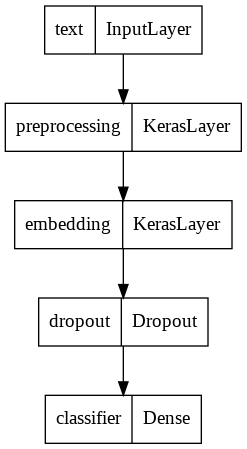

In [ ]:
tf.keras.utils.plot_model(model)

### Model training

In [ ]:
model.fit(X_train, y_train,batch_size=128, epochs=10,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)]) 

# BERT 모델 저장
model.save('Sentiment_bert.h5')

files.download('Sentiment_bert.h5')  # from colab to browser download

Epoch 1/10
469/469 [==============================] - 341s 722ms/step - loss: 0.7055 - binary_accuracy: 0.4980 - val_loss: 0.6944 - val_binary_accuracy: 0.5023
Epoch 2/10
469/469 [==============================] - 379s 808ms/step - loss: 0.6981 - binary_accuracy: 0.5005 - val_loss: 0.6925 - val_binary_accuracy: 0.5027
Epoch 3/10
469/469 [==============================] - 389s 831ms/step - loss: 0.6947 - binary_accuracy: 0.5006 - val_loss: 0.6908 - val_binary_accuracy: 0.5026
Epoch 4/10
469/469 [==============================] - 393s 838ms/step - loss: 0.6927 - binary_accuracy: 0.5014 - val_loss: 0.6910 - val_binary_accuracy: 0.5030
Epoch 5/10
 14/469 [..............................] - ETA: 4:24 - loss: 0.6938 - binary_accuracy: 0.4911

KeyboardInterrupt: ignored

In [ ]:
# Embeding
X_test_embeded = get_embeddings(X_test)

# Evaludation
accr = model.evaluate(X_test_embeded, y_test)
print('Test set\n Loss : {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

## BERT - Multi language model
기본 small bert는 영어 기반이라 baseline 만큼도 성능이 안나옴
Multilanguage 모델로 바꿔서 다시 도전

### Model builing

In [ ]:
# 양산형 모델 빌더 만들기...
def build_model(preprocessor, encoder):
    """
    Arg:
    preprocessor = 사용하려는 Model processor 주소 (Ex.'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
    encoder = 사용하려는 Model encoder 주소 (Ex. 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1')
    """
    # Input
    input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Embedding
    x = hub.KerasLayer(preprocessor, name = 'preprocessing')(input)
    x = hub.KerasLayer(encoder, name = 'embedding')(x)

    # Neural network
    x = tf.keras.layers.Dropout(0.1, name = 'dropout')(x['pooled_output']) # dropout은 왜? 없어도 되나? 성능 실험해보기
    x = tf.keras.layers.Dense(1, activation=None, name='classifier')(x)

    return tf.keras.Model(input, x)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
# multi-language
preprocessor = "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2"
encoder = "https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1"

model = build_model(preprocessor, encoder)

# # Unfreeze the base model
# model.trainable = True

model.summary()
model.compile(optimizer = 'adam', loss = loss, metrics = metrics) # RMSprop()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

### Model training

In [ ]:
# Checkpoint
n_epochs = 10

filename = 'checkpoint-epoch-{}-trial-001.h5'.format(n_epochs)
checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                             monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                             verbose=1,            # 로그를 출력합니다
                             save_best_only=True,  # 가장 best 값만 저장합니다
                             mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                            )

#Train
model_fit  = model.fit(X_train, y_train, batch_size=128, epochs=n_epochs,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)]) 

Epoch 1/10
469/469 [==============================] - 1005s 2s/step - loss: 0.5787 - binary_accuracy: 0.6656 - val_loss: 0.5428 - val_binary_accuracy: 0.7033
Epoch 2/10
469/469 [==============================] - 965s 2s/step - loss: 0.5344 - binary_accuracy: 0.7191 - val_loss: 0.5312 - val_binary_accuracy: 0.7185
Epoch 3/10
469/469 [==============================] - 951s 2s/step - loss: 0.5262 - binary_accuracy: 0.7251 - val_loss: 0.5275 - val_binary_accuracy: 0.7352
Epoch 4/10
469/469 [==============================] - 964s 2s/step - loss: 0.5241 - binary_accuracy: 0.7296 - val_loss: 0.5241 - val_binary_accuracy: 0.7317
Epoch 5/10
469/469 [==============================] - 963s 2s/step - loss: 0.5222 - binary_accuracy: 0.7297 - val_loss: 0.5242 - val_binary_accuracy: 0.7256
Epoch 6/10
469/469 [==============================] - 1034s 2s/step - loss: 0.5218 - binary_accuracy: 0.7305 - val_loss: 0.5224 - val_binary_accuracy: 0.7333
Epoch 7/10
469/469 [==============================] - 10

In [ ]:
from google.colab import files

# 모델 저장
model.save('Sentiment_multi_bert.h5')

files.download('Sentiment_multi_bert.h5')  # from colab to browser download

NameError: ignored

In [ ]:
# BERT feed 용 전처리 함수
def get_embeddings(sentences):
    processed_text = preprocessor(sentences)
    return encoder(processed_text)["pooled_output"]

In [ ]:
import numpy as np

text_test = ['this is such an amazing movie!']

X_test.apply(lambda x: get_embeddings(x))

In [ ]:
# Embeding
preprocessor = hub.KerasLayer(preprocessor)
encoder = hub.KerasLayer(encoder)

X_test_embeded = X_test.apply(lambda x: get_embeddings(x))

# Evaludation
accr = model.evaluate(X_test_embeded, y_test)
print('Test set\n Loss : {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

ValueError: ignored

In [ ]:
# 성능확인
plot_results(model_fit, 'acc')

In [ ]:
# epochs = 5
# steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
# num_train_steps = steps_per_epoch * epochs
# num_warmup_steps = int(0.1*num_train_steps)

# init_lr = 3e-5
# optimizer = optimization.create_optimizer(init_lr=init_lr,
#                                           num_train_steps=num_train_steps,
#                                           num_warmup_steps=num_warmup_steps,
#                                           optimizer_type='adamw')

In [ ]:
# 모델을 불러오는 경우
from tensorflow import keras

# load model
new_model = keras.models.load_model("/models/text_classifier_v1")

# test predictions
[np.argmax(pred) for pred in new_model.predict(reviews)]
# output: [3, 1, 0]

## Model Tunning(Bi-LSTM)
- 아래 논문 참고함   
Analysis of Accuracy and Loss Performance According to
Hyperparameter in RNN Model

### Configuration & Data processing

In [ ]:
!pip install -U keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.1 MB/s 
     |████████████████████████████████| 1.6 MB 46.6 MB/s 


In [ ]:
# Colab에 tweet tokenizer 설치
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 9.50 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 465 kB 57.0 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-12-05 00:09:56--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22e9:9f55, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bi

In [ ]:
import pandas as pd
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Bidirectional
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import keras_tuner as kt

In [ ]:
# Data
path = '/content/drive/MyDrive/0.Data for analysis/Project/steam.txt'

df = pd.read_csv(path, sep = '\t', header=None, names = ['label', 'reviews'])

# 중복제거
df.drop_duplicates(subset = 'reviews', inplace = True)

# split
label = df['label']
target = df['reviews']

X_train, X_test, y_train, y_test = train_test_split(target, label, test_size = 0.25, random_state = 42)

print('Train set count :', len(X_train))
print('Test set count :', len(X_test))

Train set count : 74919
Test set count : 24973


In [ ]:
okt = Okt()

def twit_tokenizer(text):
    # 불용어 대신 필요 없는 품사를 제거
    pos = ['Noun','Verb','Adjective','Exclamation', 'KoreanParticle'] # 관형사는 보통 한글자로 의미 알기 힘듦. 

    result = []
    for token, tag in okt.pos(text, norm=True, stem=True) :
        if tag in pos: 
            result.append(token) # steming / normalizing 도 된다....
    return result

def My_tokenizer(X_train, X_test, max_words, max_len): 
    # X_train
    tok = Tokenizer(num_words=max_words, analyzer = twit_tokenizer) # 내가 만든 토크나이저 사용 
    tok.fit_on_texts(X_train) 
    sequences = tok.texts_to_sequences(X_train)
    X_train_tokenized = pad_sequences(sequences, maxlen = max_len)

    print('Total data : ', len(X_train_tokenized), '\nPadding : ', len(X_train_tokenized[0]))

    # X_test
    sequences_t = tok.texts_to_sequences(X_test)
    X_test_tokenized = pad_sequences(sequences_t, maxlen = max_len)
    
    return X_train_tokenized, X_test_tokenized

In [ ]:
# Tokenizing

max_words = 10000
max_len = 500

X_train_tokenized, X_test_tokenized = My_tokenizer(X_train, X_test, max_words, max_len)

Total data :  74919 
Padding :  500


### Loading Model


In [ ]:
# Model loading

model = load_model('/content/drive/MyDrive/0.Data for analysis/Sentiment_Bi_LSTM.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1500)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1500, 50)          500000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              58880     
 nal)                                                            
                                                                 
 FC1 (Dense)                 (None, 256)               33024     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257       
                                                           

 ### Tunning
 우선 순위
 1. Learning rate(스케줄링)
 2. LSTM unit (16, 32, 64)
 3. Batch size(32, 34)
 4. Embedding size(논문에서는 가장 큰 영향, 200~600) 
 5. 그냥 레이어 unit
 6. drop out


In [ ]:
# Model builer : 튜닝을 위한 함수
def model_builder(hp):

    inputs = Input(name = 'inputs', shape = [max_len])
    # Embedding dim
    hp_embedding = hp.Choice('output_dim', values = [50, 100, 200, 300, 400])
    layer = Embedding(input_dim = max_words, output_dim = hp_embedding, input_length = max_len)(inputs) 
    
    # LSTM unit
    hp_units = hp.Choice('LSTM_units', values = [16, 32, 64])
    layer = Bidirectional(LSTM(hp_units))(layer) 
    
    # Dense unit
    hp_dense = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    layer = Dense(hp_dense, activation = 'relu', name = 'FC1')(layer) 
    layer = Dropout(0.5)(layer)
    layer = Dense(1, activation = 'sigmoid', name = 'out_layer')(layer)

    model = Model(inputs = inputs, outputs = layer)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [ ]:
# Tuner 지정
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 4, 
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'project tunning')

In [ ]:
tuner.search(X_train_tokenized, y_train, epochs = 10, batch_size=128, validation_data = (X_test_tokenized, y_test))

best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
최적화된 Embedding dim : {best_hps.get('output_dim')} 
최적화된 LSTM unit : {best_hps.get('LSTM_units')} 
최적화된 Dense unit : {best_hps.get('units')}
""")

Trial 10 Complete [00h 03m 15s]
val_accuracy: 0.7752372622489929

Best val_accuracy So Far: 0.7773194909095764
Total elapsed time: 00h 15m 56s

최적화된 Embedding dim : 300 
최적화된 LSTM unit : 16 
최적화된 Dense unit : 160



Trial 10 Complete [00h 03m 15s]   
val_accuracy: 0.7752372622489929   

Best val_accuracy So Far: 0.7773194909095764   
Total elapsed time: 00h 15m 56s   

최적화된 Embedding dim : 300    
최적화된 LSTM unit : 16    
최적화된 Dense unit : 160   
   
-> 첫 모델에 비해 .01 만큼 향상 
- 직접적인 성능은 크게 향상되지 않은 듯 하다

### Model training(최종)

In [ ]:
# 최종 모델
inputs = Input(name = 'inputs', shape = [max_len])
layer = Embedding(input_dim = max_words, output_dim = 300, input_length = max_len)(inputs) 
layer = Bidirectional(LSTM(16))(layer) 

layer = Dense(160, activation = 'relu', name = 'FC1')(layer) 
layer = Dropout(0.5)(layer)
layer = Dense(1, activation = 'sigmoid', name = 'out_layer')(layer)

model = Model(inputs = inputs, outputs = layer)
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

histroy = model.fit(X_train_tokenized, y_train, epochs=10, batch_size = 128,
          validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 3)]) 

# 모델 드라이브에 저장
model.save(F"/content/drive/MyDrive/0.Data for analysis/Sentiment_Bi_LSTM_v2.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 300)          3000000   
                                                                 
 bidirectional (Bidirectiona  (None, 32)               40576     
 l)                                                              
                                                                 
 FC1 (Dense)                 (None, 160)               5280      
                                                                 
 dropout (Dropout)           (None, 160)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 161       
                                                             

### Model test

In [ ]:
# Evaludation
accr = model.evaluate(X_test_tokenized, y_test)
print('Test set\n Loss : {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

781/781 [==============================] - 85s 108ms/step - loss: 0.5585 - accuracy: 0.7596
Test set
 Loss : 0.559
 Accuracy: 0.760
